# 6. Introduction to Neural Networks

**Comment entraîner vos neurones?**

<center>
<img src="https://media.geeksforgeeks.org/wp-content/cdn-uploads/20230602113310/Neural-Networks-Architecture.png">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Aperçu" data-toc-modified-id="Aperçu-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Aperçu</a></span></li><li><span><a href="#Architecture" data-toc-modified-id="Architecture-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Architecture</a></span></li><li><span><a href="#Entrainement-des-réseaux-neuronaux" data-toc-modified-id="Entrainement-des-réseaux-neuronaux-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Entrainement des réseaux neuronaux</a></span></li><li><span><a href="#Fonctions-d'activation-pour-les-couches-cachées" data-toc-modified-id="Fonctions-d'activation-pour-les-couches-cachées-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fonctions d'activation pour les couches cachées</a></span></li><li><span><a href="#Initialisation-du-poids" data-toc-modified-id="Initialisation-du-poids-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Initialisation du poids</a></span></li><li><span><a href="#Optimiseurs" data-toc-modified-id="Optimiseurs-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Optimiseurs</a></span></li><li><span><a href="#Les-réseaux-de-neurones-en-pratique" data-toc-modified-id="Les-réseaux-de-neurones-en-pratique-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Les réseaux de neurones en pratique</a></span></li><li><span><a href="#Sélection-du-modèle" data-toc-modified-id="Sélection-du-modèle-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Sélection du modèle</a></span></li><li><span><a href="#Résumé" data-toc-modified-id="Résumé-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Résumé</a></span></li></ul></div>

In [1]:
# Note: You'll need to install tensorflow-addons. One of these should work
# !pip install tensorflow_addons
# !pip install tfa-nightly

# Note: AdaMax is not yet supported in tensorflow-metal

In [2]:
# Installation automatique lors de l'exécution sur Google Colab
import os
if 'google.colab' in str(get_ipython()) and not os.path.exists('/content/master'):
    !git clone -q https://github.com/ML-course/master.git /content/master
    !pip --quiet install -r /content/master/requirements_colab.txt
    %cd master/notebooks

# Importations et paramètres globaux
%matplotlib inline
from preamble import *
interactive = True # Définir à True pour les tracés interactifs
if interactive:
    fig_scale = 1.5
else: # Pour l'affichage
    fig_scale = 0.3
    plt.rcParams.update(print_config)
    

## Aperçu
* Architectures neuronales
* Entrainement des réseaux neuronaux
    * Forward pass : opérations tensorielles
    * Backward pass : rétropropagation
* Conception de réseaux neuronaux :
    * Fonctions d'activation
    * Initialisation du poids
    * Optimiseurs
* Les réseaux de neurones en pratique
* Sélection du modèle
    * Arrêt anticipé (Early stopping)
    * Capacité de mémorisation et goulot d'étranglement de l'information
    * Régularisation L1/L2
    * Dropout
    * Normalisation par lots

In [3]:
def draw_neural_net(ax, layer_sizes, draw_bias=False, labels=False, activation=False, sigmoid=False,
                    weight_count=False, random_weights=False, show_activations=False, figsize=(4, 4)):
    """
    Draws a dense neural net for educational purposes
    Parameters:
        ax: plot axis
        layer_sizes: array with the sizes of every layer
        draw_bias: whether to draw bias nodes
        labels: whether to draw labels for the weights and nodes
        activation: whether to show the activation function inside the nodes
        sigmoid: whether the last activation function is a sigmoid
        weight_count: whether to show the number of weights and biases
        random_weights: whether to show random weights as colored lines
        show_activations: whether to show a variable for the node activations
        scale_ratio: ratio of the plot dimensions, e.g. 3/4
    """
    figsize = (figsize[0]*fig_scale, figsize[1]*fig_scale)
    left, right, bottom, top = 0.1, 0.89*figsize[0]/figsize[1], 0.1, 0.89
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    colors = ['greenyellow','cornflowerblue','lightcoral']
    w_count, b_count = 0, 0
    ax.set_xlim(0, figsize[0]/figsize[1])
    ax.axis('off')
    ax.set_aspect('equal')
    txtargs = {"fontsize":12*fig_scale, "verticalalignment":'center', "horizontalalignment":'center', "zorder":5}
    
    # Draw biases by adding a node to every layer except the last one
    if draw_bias:
        layer_sizes = [x+1 for x in layer_sizes]
        layer_sizes[-1] = layer_sizes[-1] - 1
        
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2. 
        node_size = v_spacing/len(layer_sizes) if activation and n!=0 else v_spacing/3.
        if n==0:
            color = colors[0]
        elif n==len(layer_sizes)-1:
            color = colors[2]
        else:
            color = colors[1]
        for m in range(layer_size):
            ax.add_artist(plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), radius=node_size,
                                      color=color, ec='k', zorder=4, linewidth=fig_scale))
            b_count += 1
            nx, ny = n*h_spacing + left, layer_top - m*v_spacing
            nsx, nsy = [n*h_spacing + left,n*h_spacing + left], [layer_top - m*v_spacing - 0.5*node_size*2,layer_top - m*v_spacing + 0.5*node_size*2]
            if draw_bias and m==0 and n<len(layer_sizes)-1:
                ax.text(nx, ny, r'$1$', **txtargs)
            elif labels and n==0:
                ax.text(n*h_spacing + left,layer_top + v_spacing/1.5, 'input', **txtargs)
                ax.text(nx, ny, r'$x_{}$'.format(m), **txtargs)
            elif labels and n==len(layer_sizes)-1:
                if activation:
                    if sigmoid:
                        ax.text(n*h_spacing + left,layer_top - m*v_spacing, r"$z \;\;\; \sigma$", **txtargs)
                    else:
                        ax.text(n*h_spacing + left,layer_top - m*v_spacing, r"$z_{} \;\; g$".format(m), **txtargs)
                    ax.add_artist(plt.Line2D(nsx, nsy, c='k', zorder=6))
                    if show_activations:        
                        ax.text(n*h_spacing + left + 1.5*node_size,layer_top - m*v_spacing, r"$\hat{y}$", fontsize=12*fig_scale, 
                                verticalalignment='center', horizontalalignment='left', zorder=5, c='r')

                else:
                    ax.text(nx, ny, r'$o_{}$'.format(m), **txtargs)
                ax.text(n*h_spacing + left,layer_top + v_spacing, 'output', **txtargs)
            elif labels:
                if activation:
                    ax.text(n*h_spacing + left,layer_top - m*v_spacing, r"$z_{} \;\; f$".format(m), **txtargs)
                    ax.add_artist(plt.Line2D(nsx, nsy, c='k', zorder=6))
                    if show_activations:        
                        ax.text(n*h_spacing + left + node_size*1.2 ,layer_top - m*v_spacing, r"$a_{}$".format(m), fontsize=12*fig_scale, 
                                verticalalignment='center', horizontalalignment='left', zorder=5, c='b')
                else:
                    ax.text(nx, ny, r'$h_{}$'.format(m), **txtargs)
                
            
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                if not (draw_bias and o==0 and len(layer_sizes)>2 and n<layer_size_b-1):
                    xs = [n*h_spacing + left, (n + 1)*h_spacing + left]
                    ys = [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing]
                    color = 'k' if not random_weights else plt.cm.bwr(np.random.random())
                    ax.add_artist(plt.Line2D(xs, ys, c=color, alpha=0.6))
                    if not (draw_bias and m==0):
                        w_count += 1
                    if labels and not random_weights:
                        wl = r'$w_{{{},{}}}$'.format(m,o) if layer_size_b>1 else r'$w_{}$'.format(m)
                        ax.text(xs[0]+np.diff(xs)/2, np.mean(ys)-np.diff(ys)/9, wl, ha='center', va='center', 
                                 fontsize=12*fig_scale)
    # Count
    if weight_count:
        b_count = b_count - layer_sizes[0]
        if draw_bias:
            b_count = b_count - (len(layer_sizes) - 2)
        ax.text(right*1.05, bottom, "{} weights, {} biases".format(w_count, b_count), ha='center', va='center')


## Architecture
* Régression logistique, dessinée d'une manière différente, inspirée par la neuro science
 * Modèle linéaire : produit interne ($z$) du vecteur d'entrée $\mathbf{x}$ et du vecteur de poids $\mathbf{w}$, plus biais $w_0$
 * La fonction logistique (ou sigmoïde) fait correspondre la sortie à une probabilité en [0,1]
 * Utilise la log loss(entropie croisée) et la descente de gradient pour apprendre les poids

$$\hat{y}(\mathbf{x}) = \text{sigmoid}(z) = \text{sigmoid}(w_0 + \mathbf{w}\mathbf{x}) = \text{sigmoid}(w_0 + w_1 * x_1 + w_2 * x_2 +... + w_p * x_p)$$

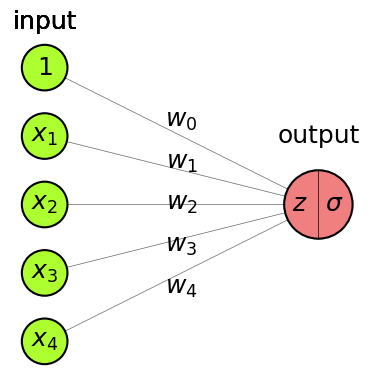

In [4]:
fig = plt.figure(figsize=(3*fig_scale,3*fig_scale))
ax = fig.gca()
draw_neural_net(ax, [4, 1], activation=True, draw_bias=True, labels=True, sigmoid=True)

### Architecture de base
* Ajoutez une (ou plusieurs) couches _cachées_ $h$ avec $k$ nœuds (ou unités, cellules, neurones)
 * Chaque « neurone » est une fonction minuscule, le réseau est une fonction arbitrairement complexe
 * Les poids $w_{i,j}$ entre le nœud $i$ et le nœud $j$ forment une matrice de poids $\mathbf{W}^{(l)}$ par couche $l$
* Chaque neurone pondère les entrées $\mathbf{x}$ et les transmet via une fonction d'activation non linéaire
 * Les fonctions d'activation ($f,g$) peuvent être différentes selon les couches, la sortie $\mathbf{a}$ est appelée activation
$$\color{blue}{h(\mathbf{x})} = \color{blue}{\mathbf{a}} = f(\mathbf{z}) = f(\mathbf{W}^{(1)} \color{green}{\mathbf{x}}+\mathbf{w}^{(1)}_0) \quad \quad \color{red}{o(\mathbf{x})} = g(\mathbf{W}^{(2)}  \color{blue}{\mathbf{a}}+\mathbf{w}^{(2)}_0)$$

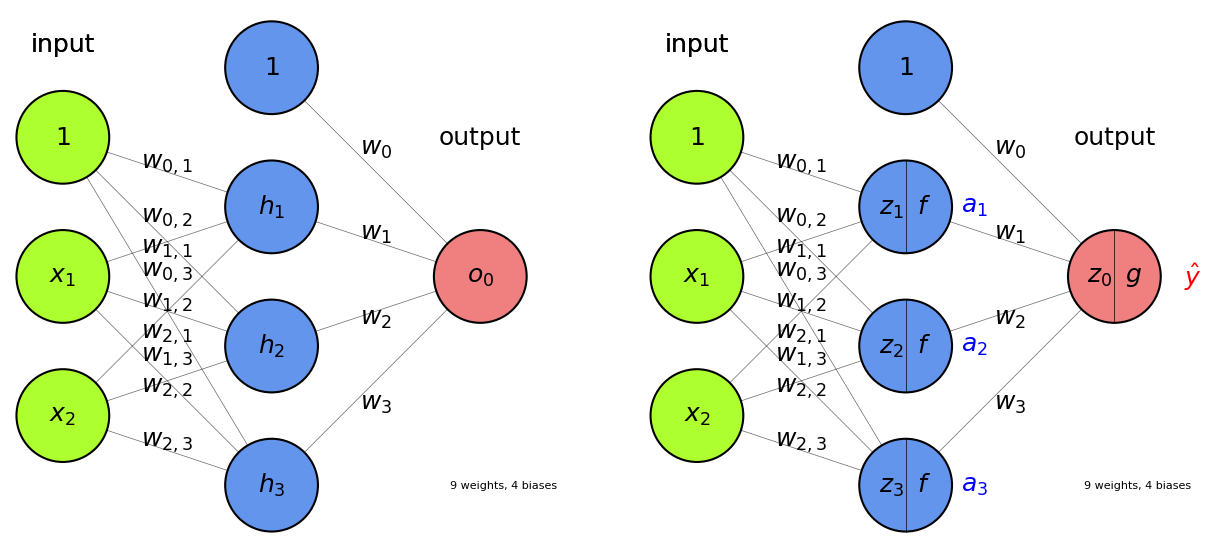

In [5]:
fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,5*fig_scale))
draw_neural_net(axes[0], [2, 3, 1],  draw_bias=True, labels=True, weight_count=True, figsize=(4, 4))
draw_neural_net(axes[1], [2, 3, 1],  activation=True, show_activations=True, draw_bias=True, 
                labels=True, weight_count=True,  figsize=(4, 4))

### Plus de couches
* Ajoutez plus de couches et plus de nœuds par couche pour rendre le modèle plus complexe
    * Par simplicité, nous ne dessinons pas les biais (mais rappelez-vous qu'ils sont là)
* Dans les couches _dense_ (entièrement connectées), chaque nœud de la couche précédente est connecté à tous les nœuds
* La couche de sortie peut également avoir plusieurs nœuds (par exemple 1 par classe dans une classification multi-classe)

In [6]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def plot_dense_net(nr_layers=(0,6,1), nr_nodes=(1,12,1)):
    fig = plt.figure(figsize=(10*fig_scale, 5*fig_scale))
    ax = fig.gca()
    ax.axis('off')
    hidden = [nr_nodes]*nr_layers
    draw_neural_net(ax, [5] + hidden + [5], weight_count=True, figsize=(6, 4));

interactive(children=(IntSlider(value=3, description='nr_layers', max=6), IntSlider(value=6, description='nr_n…

In [7]:
if not interactive:
    plot_dense_net(nr_layers=6, nr_nodes=10)

### Pourquoi les couches ?
* Chaque couche agit comme un _filtre_ et apprend une nouvelle _représentation_ des données
    * Les couches suivantes peuvent apprendre des raffinements itératifs
    * Plus facile que d'apprendre une relation complexe en une seule fois
* Exemple : pour les images en entree, chaque couche génère de nouvelles images (filtrées)
    * Peut apprendre plusieurs fonctions à la fois : le _tenseur_ de poids  $\mathit{W}$ donne le tenseur d'activation $\mathit{A}$
    * Depuis les modèles de bas niveau (bords, points finaux, ...) jusqu'à leurs combinaisons
    * Chaque neurone « s'allume » si certains schemas se produisent dans l'entrée

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/00_layers2.png" alt="ml" style="width : 50%"/>

### Autres architectures
* Il existe de NOMBREUX types de réseaux pour de nombreuses tâches différentes
* Réseaux convolutifs pour les données d'images, Réseaux récurrents pour les données séquentielles,...
* Également utilisé pour apprendre des représentations (embeddings), générer de nouvelles images, textes,...

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/neural_zoo.png" alt="ml" style="width: 1200px;"/>

## Entrainement des réseaux neuronaux
* Concevoir l'architecture, choisir les fonctions d'activation (ex. sigmoïdes)
* Choisissez une manière d'initialiser les poids (par exemple, initialisation aléatoire)
* Choisissez une _fonction de perte_ (par exemple, perte de journal) pour mesurer dans quelle mesure le modèle s'adapte aux données d'entraînement
* Choisissez un _optimiseur_ (généralement une variante SGD) pour mettre à jour les poids

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/09_overview.png" alt="ml" style="width: 45%"/>

### Descente de gradient stochastique en mini-batchs (récapitulatif)
1. Tirez un lot de données d'entraînement de taille *batch_size* $\mathbf{X}$ et $\mathbf{y}$
2. _Forward pass_ : passez $\mathbf{X}$ à travers le réseau pour générer des prédictions $\mathbf{\hat{y}}$
3. Calculez la perte $\mathcal{L}$ (inadéquation entre $\mathbf{\hat{y}}$ et $\mathbf{y}$)
4. _Backward pass_ : Calculez le gradient de la perte par rapport à chaque poids
     * _Backpropagate_ les gradients a travers toutes les couches
5. Mettre à jour $W$ : $W_{(i+1)} = W_{(i)} - \frac{\partial L(x, W_{(i)})}{\partial W} * \eta$

Répétez jusqu'à ce que n passes (époques) soient effectuées sur l'ensemble d'entraînement.

In [8]:
# TODO: show the actual weight updates
@interact
def draw_updates(iteration=(1,100,1)):
    fig, ax = plt.subplots(1, 1, figsize=(6*fig_scale, 4*fig_scale))
    np.random.seed(iteration)
    draw_neural_net(ax, [6,5,5,3], labels=True, random_weights=True, show_activations=True, figsize=(6, 4));

interactive(children=(IntSlider(value=50, description='iteration', min=1), Output()), _dom_classes=('widget-in…

In [9]:
if not interactive:
    draw_updates(iteration=1)

### Forward pass
* Nous pouvons naturellement représenter les données sous forme de _tenseurs_
 * Tableau numérique à n dimensions (avec n axes)
 * Tenseur 2D : matrice (échantillons, variables)
 * Tenseur 3D : séries temporelles (échantillons, pas de temps, variables)
 * Tenseur 4D : images couleur (échantillons, hauteur, largeur, canaux)
 * Tenseur 5D : vidéo (échantillons, images, hauteur, largeur, canaux)
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/08_timeseries.png" alt="ml" style="float: left; width: 30%;"/>
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/08_images.png" alt="ml" style="float: left; width: 30%;"/>

#### Opérations tensorielles
* Les opérations que le réseau effectue sur les données peuvent être réduites à une _série d'opérations tensorielles_
 * Ceux-ci sont également beaucoup plus faciles à exécuter sur des GPU
* Une couche dense avec activation sigmoïde, tenseur d'entrée $\mathbf{X}$, tenseur de poids $\mathbf{W}$, biais $\mathbf{b}$ :

```python
y = sigmoïde (np.dot (X, W) + b)
```
* Produit scalaire tensoriel pour les entrées 2D ($a$ échantillons, $b$ variables, $c$ nœuds cachés)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/08_dot.png" alt="ml" style="width: 40%"/>

#### Opérations par élément

* Les fonctions d'activation et d'ajout sont des opérations par éléments :

```python
def sigmoid(x):
 return 1/(1 + np.exp(-x))

def ajouter (x, y):
 return x + y
```

* Remarque : si y a une dimension inférieure à x, elle sera _diffusée_ : des axes sont ajoutés pour correspondre à la dimensionnalité, et y est répété le long des nouveaux axes

``` python
>>> np.array([[1,2],[3,4]]) + np.array([10,20])
array([[11, 22],
       [13, 24]])
```

### Backward pass (rétropropagation)
* Pour la dernière couche, calculez le gradient de la fonction de perte $\mathcal{L}$ par rapport à tous les poids de la couche $l$

$$\nabla \mathcal{L} = \frac{\partial \mathcal{L}}{\partial W^{(l)}} =
 \begin{bmatrix}
 \frac{\partial \mathcal{L}}{\partial w_{0,0}} & \ldots & \frac{\partial \mathcal{L}}{\partial w_{0,l}} \\
 \vdots & \ddots & \vdots \\
 \frac{\partial \mathcal{L}}{\partial w_{k,0}} & \ldots & \frac{\partial \mathcal{L}}{\partial w_{k,l}}
 \end{bmatrix}$$

* Additionnez les gradients de tous les $\mathbf{x}_j$ du minibatch : $\sum_{j} \frac{\partial \mathcal{L}(\mathbf{x}_j,y_j)}{\partial W^ {(l)}}$
* Mettre à jour tous les poids d'une couche en même temps (avec un taux d'apprentissage $\eta$) : $W_{(i+1)}^{(l)} = W_{(i)}^{(l)} - \eta \sum_{j} \frac{\partial \mathcal{L}(\mathbf{x}_j,y_j)}{\partial W_{(i)}^{(l)}}$
* Répétez l'opération pour la couche suivante, en itérant vers l'arrière (le plus efficace, évite les calculs redondants)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/01_gradient_descent.jpg" alt="ml" style="width : 40%"/>

#### Exemple
* Imaginez alimenter un seul point de données, la sortie est $\hat{y} = g(z) = g(w_0 + w_1 * a_1 + w_2 * a_2 +... + w_p * a_p)$
* Diminuez les pertes en mettant à jour les poids :
 * Mettez à jour les poids de la dernière couche pour maximiser l'amélioration :
 $w_{i,(nouveau)} = w_{i} - \frac{\partial \mathcal{L}}{\partial w_i} * \eta$
 * Pour calculer le gradient $\frac{\partial \mathcal{L}}{\partial w_i}$ nous avons besoin de la règle de chaîne : $f(g(x)) = f'(g(x)) * g'(x )$
$$\frac{\partial \mathcal{L}}{\partial w_i} = \color{red}{\frac{\partial \mathcal{L}}{\partial g}} \color{blue}{\frac {\partial \mathcal{g}}{\partial z_0}} \color{green}{\frac{\partial \mathcal{z_0}}{\partial w_i}}$$
* Par exemple, avec $\mathcal{L} = \frac{1}{2}(y-\hat{y})^2$ et sigmoïde $\sigma$ : $\frac{\partial \mathcal{L}} {\partial w_i} = \color{red}{(y - \hat{y})} * \color{blue}{\sigma'(z_0)} * \color{green}{a_i}$

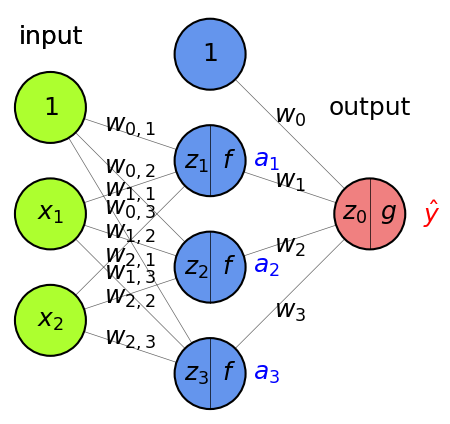

In [10]:
fig = plt.figure(figsize=(4*fig_scale, 3.5*fig_scale))
ax = fig.gca()
draw_neural_net(ax, [2, 3, 1],  activation=True, draw_bias=True, labels=True, 
                show_activations=True)

#### Rétropropagation (2)
* Une autre façon de diminuer la perte $\mathcal{L}$ est de mettre à jour les activations $a_i$
 * Pour mettre à jour $a_i = f(z_i)$, nous devons mettre à jour les poids de la couche précédente
 * Nous voulons pousser $a_i$ dans la bonne direction en mettant à jour $w_{i,j}$ :
$$\frac{\partial \mathcal{L}}{\partial w_{i,j}} = \frac{\partial \mathcal{L}}{\partial a_i} \frac{\partial a_i}{\partial z_i} \frac{\partial \mathcal{z_i}}{\partial w_{i,j}} = \left( \frac{\partial \mathcal{L}}{\partial g} \frac{\partial \mathcal{g}}{\partial z_0} \frac{\partial \mathcal{z_0}}{\partial a_i} \right) \frac{\partial a_i}{\partial z_i} \frac{\partial \mathcal{z_i}}{\partial w_{i,j}}$$
    * Nous connaissons $\frac{\partial \mathcal{L}}{\partial g}$ et $\frac{\partial \mathcal{g}}{\partial z_0}$ de l'etape precedente, $\frac{\partial \mathcal{z_0}}{\partial a_i} = w_i$, $\frac{\partial a_i}{\partial z_i} = f'$ et $\frac{\partial \mathcal{z_i}}{\partial w_{i,j}} = x_j$

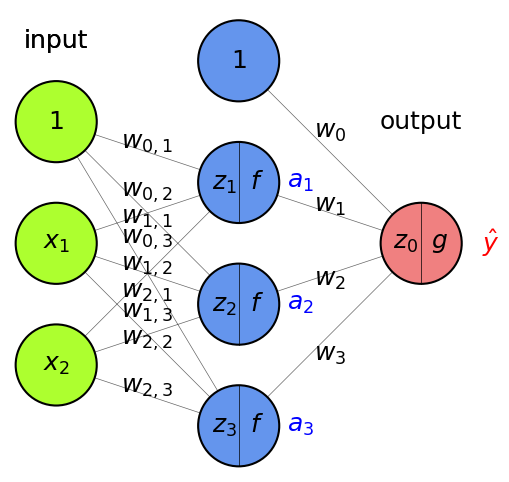

In [11]:
fig = plt.figure(figsize=(4*fig_scale, 4*fig_scale))
ax = fig.gca()
draw_neural_net(ax, [2, 3, 1],  activation=True, draw_bias=True, labels=True, 
                show_activations=True)

#### Rétropropagation (3)
* Avec plusieurs nœuds de sortie, $\mathcal{L}$ est la somme de toutes les pertes par sortie (par classe)
     * $\frac{\partial \mathcal{L}}{\partial a_i}$ est la somme des gradients pour chaque sortie
* Par couche, résumez les dégradés pour chaque point $\mathbf{x}$ du lot : $\sum_{j} \frac{\partial \mathcal{L}(\mathbf{x}_j,y_j)}{\ partiel W}$
* Mettre à jour tous les poids de chaque couche $l$
     * $W_{(i+1)}^{(l)} = W_{(i)}^{(l)} - \eta \sum_{j} \frac{\partial \mathcal{L}(\mathbf {x}_j,y_j)}{\partial W_{(i)}^{(l)}}$
* Répétez avec un nouveau lot de données jusqu'à ce que la perte converge
* [Belle animation de l'ensemble du processus](https://youtu.be/Ilg3gGewQ5U?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&t=403)

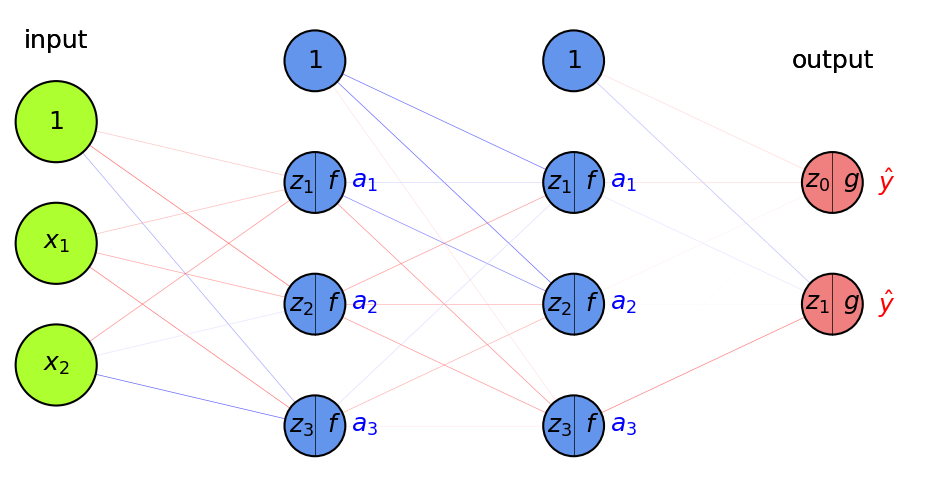

In [12]:
fig = plt.figure(figsize=(8*fig_scale, 4*fig_scale))
ax = fig.gca()
draw_neural_net(ax, [2, 3, 3, 2],  activation=True, draw_bias=True, labels=True, 
                random_weights=True, show_activations=True, figsize=(8, 4))

#### Résumé
* La sortie du réseau $a_o$ est définie par les poids $W^{(o)}$ et les biais $\mathbf{b}^{(o)}$ de la couche de sortie, et
* Les activations d'une couche cachée $h_1$ avec fonction d'activation $a_{h_1}$, des poids $W^{(1)}$ et des biais $\mathbf{b^{(1)}}$ :

$$\color{red}{a_o(\mathbf{x})} = \color{red}{a_o(\mathbf{z_0})} = \color{red}{a_o(W^{(o)}} \color{blue}{a_{h_1}(z_{h_1})} \color{red}{+ \mathbf{b}^{(o)})} = \color{red}{a_o(W^{( o)}} \color{blue}{a_{h_1}(W^{(1)} \color{green}{\mathbf{x}} + \mathbf{b}^{(1)})}
 \color{rouge}{+ \mathbf{b}^{(o)})} $$

* Minimiser la perte par SGD. Pour la couche $l$, calculez $\frac{\partial \mathcal{L}(a_o(x))}{\partial W_l}$ et $\frac{\partial \mathcal{L}(a_o(x))} {\partial b_{l,i}}$ en utilisant la règle de chaîne
* Se décompose en <span style="color:red">en gradient de la couche ci-dessus</span>, <span style="color:blue">gradient de la fonction d'activation</span>, <span style="color:green" >gradient de la couche d'entree</span> :

$$\frac{\partial \mathcal{L}(a_o)}{\partial W^{(1)}} = \color{red}{\frac{\partial \mathcal{L}(a_o)}{\partial a_{h_1}}} \color{blue}{\frac{\partial a_{h_1}}{\partial z_{h_1}}} \color{green}{\frac{\partial z_{h_1}}{\partial W^{(1)}}} 
= \left( \color{red}{\frac{\partial \mathcal{L}(a_o)}{\partial a_o}} \color{blue}{\frac{\partial a_o}{\partial z_o}} \color{green}{\frac{\partial z_o}{\partial a_{h_1}}}\right) \color{blue}{\frac{\partial a_{h_1}}{\partial z_{h_1}}} \color{green}{\frac{\partial z_{h_1}}{\partial W^{(1)}}}  $$

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/backprop_schema2.png" alt="ml" style="width: 800px;"/>

## Fonctions d'activation pour les couches cachées
* Sigmoïde : $f(z) = \frac{1}{1+e^{-z}}$
* Tanh : $f(z) = \frac{2}{1+e^{-2z}} - 1$
 * Les activations autour de 0 sont meilleures pour la convergence par descente de gradient
* Linéaire Rectifié (ReLU) : $f(z) = max(0,z)$
 * Moins lisse, mais beaucoup plus rapide (attention : non dérivable à 0)
* Leaky ReLU : $f(z) = \begin{cases} 0,01z & z<0 \\ z & sinon \end{cases}$

In [13]:
def activation(X, function="sigmoid"):     
    if function == "sigmoid":      
        return 1.0/(1.0 + np.exp(-X))    
    if function == "softmax": 
        return np.exp(X) / np.sum(np.exp(X), axis=0)   
    elif function == "tanh":      
        return np.tanh(X)    
    elif function == "relu":      
        return np.maximum(0,X)    
    elif function == "leaky_relu":      
        return np.maximum(0.1*X,X)
    elif function == "none":      
        return X
    
def activation_derivative(X, function="sigmoid"):   
    if function == "sigmoid": 
        sig = 1.0/(1.0 + np.exp(-X))   
        return sig * (1 - sig)
    elif function == "tanh":      
        return 1 - np.tanh(X)**2   
    elif function == "relu":      
        return np.where(X > 0, 1, 0)
    elif function == "leaky_relu":    
        # Using 0.1 instead of 0.01 to make it visible in the plot
        return np.where(X > 0, 1, 0.1)
    elif function == "none":      
        return X/X
    
def plot_activation(function, ax, derivative=False):
    if function=="softmax":       
        x = np.linspace(-6,6,9)
        ax.plot(x,activation(x, function),lw=2, c='b', linestyle='-', marker='o')
    else:     
        x = np.linspace(-6,6,101)
        ax.plot(x,activation(x, function),lw=2, c='b', linestyle='-') 
        if derivative:
            if function == "relu" or function == "leaky_relu":
                ax.step(x,activation_derivative(x, function),lw=2, c='r', linestyle='-')
            else:
                ax.plot(x,activation_derivative(x, function),lw=2, c='r', linestyle='-')
    ax.set_xlabel("input", fontsize=16*fig_scale)
    ax.set_ylabel(function, fontsize=18*fig_scale)
    ax.tick_params(axis='both', labelsize=16*fig_scale)
    ax.grid()
    
functions = ["sigmoid","tanh","relu","leaky_relu"]

@interact
def plot_activations(function=functions):
    fig, ax = plt.subplots(figsize=(5,1.5))
    plot_activation(function, ax)

interactive(children=(Dropdown(description='function', options=('sigmoid', 'tanh', 'relu', 'leaky_relu'), valu…

In [14]:
if not interactive:
    fig, axes = plt.subplots(1,4, figsize=(10,2))
    for function, ax in zip(functions,axes):
        plot_activation(function, ax)
    plt.tight_layout();

#### Effet des fonctions d'activation sur le gradient
* Lors de la descente du gradient, le gradient dépend de la fonction d'activation $a_{h}$ : $\frac{\partial \mathcal{L}(a_o)}{\partial W^{(l)}} = \color{red }{\frac{\partial \mathcal{L}(a_o)}{\partial a_{h_l}}} \color{blue}{\frac{\partial a_{h_l}}{\partial z_{h_l}}} \color{green}{\frac{\partial z_{h_l}}{\partial W^{(l)}}}$
* Si la dérivée de la fonction d'activation $\color{blue}{\frac{\partial a_{h_l}}{\partial z_{h_l}}}$ est 0, les poids $w_i$ ne sont pas mis à jour
 * De plus, les gradients des couches précédentes seront réduits ( disparition du gradient)
* sigmoïde, tanh : le gradient est très faible pour les grandes entrées : mises à jour lentes
* Avec ReLU, $\color{blue}{\frac{\partial a_{h_l}}{\partial z_{h_l}}} = 1$ si $z>0$, donc mieux contre la disparition des gradients
 * Problème : pour les entrées très négatives, le gradient est de 0 et peut ne jamais se rétablir (ReLU mourant)
 * Leaky ReLU a un petit gradient (0,01) pour permettre la récupération

In [15]:
@interact
def plot_activations_derivative(function=functions):
    fig, ax = plt.subplots(figsize=(6,2))
    plot_activation(function, ax, derivative=True)
    plt.legend(['original','derivative'], loc='upper center', 
               bbox_to_anchor=(0.5, 1.25), ncol=2)

interactive(children=(Dropdown(description='function', options=('sigmoid', 'tanh', 'relu', 'leaky_relu'), valu…

In [16]:
if not interactive:
    fig, axes = plt.subplots(1,4, figsize=(10,2))
    for function, ax in zip(functions,axes):
        plot_activation(function, ax, derivative=True)
    fig.legend(['original','derivative'], loc='upper center', 
               bbox_to_anchor=(0.5, 1.25), ncol=2)
    plt.tight_layout();

#### ReLU contre Tanh
* Quel est l'effet de l'utilisation de fonctions d'activation non lisses ?
 * ReLU produit des limites linéaires par morceaux, mais permet des réseaux plus profonds
 * Tanh produit des limites de décision plus lisses, mais est plus lent

In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from mglearn.plot_2d_separator import plot_2d_classification
import time

@interact
def plot_boundary(nr_layers=(1,4,1)):
    X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                        random_state=42)
    
    # Multi-Layer Perceptron with ReLU
    mlp = MLPClassifier(solver='lbfgs', random_state=0,
                        hidden_layer_sizes=[10]*nr_layers)
    start = time.time()
    mlp.fit(X_train, y_train)
    relu_time = time.time() - start
    relu_acc = mlp.score(X_test, y_test)

    # Multi-Layer Perceptron with tanh
    mlp_tanh = MLPClassifier(solver='lbfgs', activation='tanh',
                             random_state=0, hidden_layer_sizes=[10]*nr_layers)
    start = time.time()
    mlp_tanh.fit(X_train, y_train)
    tanh_time = time.time() - start
    tanh_acc = mlp_tanh.score(X_test, y_test)

    fig, axes = plt.subplots(1, 2, figsize=(8*fig_scale, 4*fig_scale))
    axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', label="train")
    axes[0].set_title("ReLU, acc: {:.2f}, time: {:.2f} sec".format(relu_acc, relu_time))
    plot_2d_classification(mlp, X_train, fill=True, cm='bwr', alpha=.3, ax=axes[0])
    axes[1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', label="train")
    axes[1].set_title("tanh, acc: {:.2f}, time: {:.2f} sec".format(tanh_acc, tanh_time))
    plot_2d_classification(mlp_tanh, X_train, fill=True, cm='bwr', alpha=.3, ax=axes[1])

interactive(children=(IntSlider(value=2, description='nr_layers', max=4, min=1), Output()), _dom_classes=('wid…

In [18]:
if not interactive:
    plot_boundary(nr_layers=2)

#### Fonctions d'activation pour la couche de sortie
* _sigmoïde_ convertit la sortie en probabilité en [0,1]
 * Pour la classification binaire
* _softmax_ convertit toutes les sorties (alias « logits ») en probabilités dont la somme atteint 1
 * Pour la classification multi-classes ($k$ classes)
 * Peut provoquer des modèles trop confiants. Si c'est le cas, lissez les étiquettes : $y_{smooth} = (1-\alpha)y + \frac{\alpha}{k}$
$$\text{softmax}(\mathbf{x},i) = \frac{e^{x_i}}{\sum_{j=1}^k e^{x_j}}$$
* Pour la régression, n'utilisez aucune fonction d'activation, laissez le modèle apprendre la cible exacte

In [19]:
output_functions = ["sigmoid","softmax","none"]

@interact
def plot_output_activation(function=output_functions):
    fig, ax = plt.subplots(figsize=(6,2))
    plot_activation(function, ax)

interactive(children=(Dropdown(description='function', options=('sigmoid', 'softmax', 'none'), value='sigmoid'…

In [20]:
if not interactive:
    fig, axes = plt.subplots(1,2, figsize=(8,2))
    for function, ax in zip(output_functions[:2],axes):
        plot_activation(function, ax)
    plt.tight_layout();

## Initialisation du poids
* Initialiser les poids à 0 est mauvais : tous les gradients de la couche seront identiques (symétrie)
* Des poids aléatoires trop petits réduisent les activations à 0 le long des couches (gradient en voie de disparition)
* Des poids aléatoires trop importants se multiplient le long des couches (gradient explosif, zigzag)
* Idéal : petits poids aléatoires + la variance des gradients d'entrée et de sortie reste la même
 * Initialisation Glorot/Xavier (pour tanh) : échantillon aléatoire à partir de $N(0,\sigma), \sigma = \sqrt{\frac{2}{\text{fan_in + fan_out}}}$
 * fan_in : nombre d'unités d'entrée, fan_out : nombre d'unités de sortie
 * Initialisation (pour ReLU) : échantillon aléatoire à partir de $N(0,\sigma), \sigma = \sqrt{\frac{2}{\text{fan_in}}}$
 * Échantillonnage uniforme (au lieu de $N(0,\sigma)$) pour les réseaux plus profonds (par rapport aux gradients qui disparaissent)

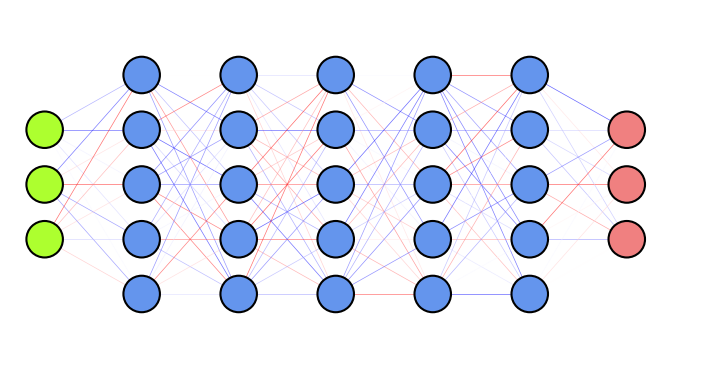

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6*fig_scale, 3*fig_scale))
draw_neural_net(ax, [3, 5, 5, 5, 5, 5, 3], random_weights=True, figsize=(6, 3))

### Initialisation du poids : apprentissage par transfert
* Au lieu de repartir de zéro, partez des poids précédemment appris lors de tâches similaires.
 * C'est, dans une large mesure, ainsi que les humains apprennent si vite
* Apprentissage par transfert : apprenez les poids sur la tâche T, transférez-les vers un nouveau réseau
 * Les poids peuvent être gelés ou ajustés aux nouvelles données
* Ne fonctionne que si la tâche précédente est suffisamment « similaire »
 * Généralement, les poids appris sur des données très diverses (par exemple ImageNet) sont mieux transférés
 * Meta-learning : apprenez une bonne initialisation à travers de nombreuses tâches connexes

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/transfer_learning.png" alt="ml" style="width: 1000px;"/>

In [22]:
import tensorflow as tf
import tensorflow_addons as tfa

# Toy surface
def f(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

# Tensorflow optimizers
sgd = tf.optimizers.SGD(0.01)
lr_schedule = tf.optimizers.schedules.ExponentialDecay(0.02,decay_steps=100,decay_rate=0.96)
sgd_decay = tf.optimizers.SGD(learning_rate=lr_schedule)
#sgd_cyclic = tfa.optimizers.CyclicalLearningRate(initial_learning_rate= 0.1, maximal_learning_rate= 0.5, step_size=0.05)
clr_schedule = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-4, maximal_learning_rate= 0.1, 
                                                   step_size=100, scale_fn=lambda x : x)
sgd_cyclic = tf.optimizers.SGD(learning_rate=clr_schedule)
momentum = tf.optimizers.SGD(0.005, momentum=0.9, nesterov=False)
nesterov = tf.optimizers.SGD(0.005, momentum=0.9, nesterov=True)
adagrad = tf.optimizers.Adagrad(0.4)
#adamax = tf.optimizers.Adamax(learning_rate=0.5, beta_1=0.9, beta_2=0.999) # AdaMax is still not supported in tensorflow-metal
#adadelta = tf.optimizers.Adadelta(learning_rate=1.0)
rmsprop = tf.optimizers.RMSprop(learning_rate=0.1)
#rmsprop_momentum = tf.optimizers.RMSprop(learning_rate=0.1, momentum=0.9)
adam = tf.optimizers.Adam(learning_rate=0.2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

optimizers = [sgd, sgd_decay, momentum, nesterov, adagrad, rmsprop, adam, sgd_cyclic] #, adamax]
opt_names = ['sgd', 'sgd_decay', 'momentum', 'nesterov', 'adagrad', 'rmsprop', 'adam', 'sgd_cyclic'] #,'adamax']
cmap = plt.cm.get_cmap('tab10')
colors = [cmap(x/10) for x in range(10)]

# Training
all_paths = []
for opt, name in zip(optimizers, opt_names):
    x = tf.Variable(0.8)
    y = tf.Variable(1.6)

    x_history = []
    y_history = []
    loss_prev = 0.0
    max_steps = 100
    for step in range(max_steps):
        with tf.GradientTape() as g:
            loss = f(x, y)
            x_history.append(x.numpy())
            y_history.append(y.numpy())
            grads = g.gradient(loss, [x, y])
            opt.apply_gradients(zip(grads, [x, y]))

    if np.abs(loss_prev - loss.numpy()) < 1e-6:
        break
    loss_prev = loss.numpy()
    x_history = np.array(x_history)
    y_history = np.array(y_history)
    path = np.concatenate((np.expand_dims(x_history, 1), np.expand_dims(y_history, 1)), axis=1).T
    all_paths.append(path)

2024-07-06 09:23:54.920487: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-06 09:23:54.959399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 09:23:54.959444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 09:23:54.960400: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-06 09:23:54.966115: I tensorflow/core/platform/cpu_feature_guar

In [23]:
# Plotting
number_of_points = 50
margin = 4.5
minima = np.array([3., .5])
minima_ = minima.reshape(-1, 1)
x_min = 0. - 2
x_max = 0. + 3.5
y_min = 0. - 3.5
y_max = 0. + 2
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

def plot_optimizers(ax, iterations, optimizers):
    ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-0.5, 5, 25), norm=LogNorm(), cmap=plt.cm.jet, linewidths=fig_scale, zorder=-1)
    ax.plot(*minima, 'r*', markersize=20*fig_scale)
    for name, path, color in zip(opt_names, all_paths, colors):
        if name in optimizers:
            p = path[:,:iterations]
            ax.plot([], [], color=color, label=name, lw=3*fig_scale, linestyle='-')
            ax.quiver(p[0,:-1], p[1,:-1], p[0,1:]-p[0,:-1], p[1,1:]-p[1,:-1], scale_units='xy', angles='xy', scale=1, color=color, lw=4)


    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))
    ax.legend(loc='lower left', prop={'size': 15*fig_scale}) 
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

In [24]:
from decimal import *
from matplotlib.colors import LogNorm

# Training for momentum
all_lr_paths = []
lr_range = [0.005 * i for i in range(0,10)]
for lr in lr_range:
    opt = tf.optimizers.SGD(lr, nesterov=False)

    x_init = 0.8
    x = tf.compat.v1.get_variable('x', dtype=tf.float32, initializer=tf.constant(x_init))
    y_init = 1.6
    y = tf.compat.v1.get_variable('y', dtype=tf.float32, initializer=tf.constant(y_init))

    x_history = []
    y_history = []
    z_prev = 0.0
    max_steps = 100
    for step in range(max_steps):
        with tf.GradientTape() as g:
            z = f(x, y)
            x_history.append(x.numpy())
            y_history.append(y.numpy())
            dz_dx, dz_dy = g.gradient(z, [x, y])
            opt.apply_gradients(zip([dz_dx, dz_dy], [x, y]))

    if np.abs(z_prev - z.numpy()) < 1e-6:
        break
    z_prev = z.numpy()
    x_history = np.array(x_history)
    y_history = np.array(y_history)
    path = np.concatenate((np.expand_dims(x_history, 1), np.expand_dims(y_history, 1)), axis=1).T
    all_lr_paths.append(path)
    
# Plotting
number_of_points = 50
margin = 4.5
minima = np.array([3., .5])
minima_ = minima.reshape(-1, 1)
x_min = 0. - 2
x_max = 0. + 3.5
y_min = 0. - 3.5
y_max = 0. + 2
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

def plot_learning_rate_optimizers(ax, iterations, lr):
    ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-0.5, 5, 25), norm=LogNorm(), cmap=plt.cm.jet, linewidths=fig_scale, zorder=-1)
    ax.plot(*minima, 'r*', markersize=20*fig_scale)
    for path, lrate in zip(all_lr_paths, lr_range):
        if round(lrate,3) == lr:
            p = path[:,:iterations]
            ax.plot([], [], color='b', label="Learning rate {}".format(lr), lw=3*fig_scale, linestyle='-')
            ax.quiver(p[0,:-1], p[1,:-1], p[0,1:]-p[0,:-1], p[1,1:]-p[1,:-1], scale_units='xy', angles='xy', scale=1, color='b', lw=4)


    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))
    ax.legend(loc='lower left', prop={'size': 15*fig_scale}) 
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

In [25]:
# Toy plot to illustrate nesterov momentum
# TODO: replace with actual gradient computation?
def plot_nesterov(ax, method="Nesterov momentum"):
    ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-0.5, 5, 25), norm=LogNorm(), cmap=plt.cm.jet, linewidths=fig_scale, zorder=-1)
    ax.plot(*minima, 'r*', markersize=20*fig_scale)
    
    # toy example
    ax.quiver(-0.8,-1.13,1,1.33, scale_units='xy', angles='xy', scale=1, color='k', alpha=0.5, lw=3, label="previous update")
    # 0.9 * previous update
    ax.quiver(0.2,0.2,0.9,1.2, scale_units='xy', angles='xy', scale=1, color='g', lw=3, label="momentum step")
    if method == "Momentum":
        ax.quiver(0.2,0.2,0.5,0, scale_units='xy', angles='xy', scale=1, color='r', lw=3, label="gradient step")
        ax.quiver(0.2,0.2,0.9*0.9+0.5,1.2, scale_units='xy', angles='xy', scale=1, color='b', lw=3, label="actual step")
    if method == "Nesterov momentum":
        ax.quiver(1.1,1.4,-0.2,-1, scale_units='xy', angles='xy', scale=1, color='r', lw=3, label="'lookahead' gradient step")
        ax.quiver(0.2,0.2,0.7,0.2, scale_units='xy', angles='xy', scale=1, color='b', lw=3, label="actual step")

    ax.set_title(method)
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((-2.5, y_max))
    ax.legend(loc='lower right', prop={'size': 9*fig_scale})
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

## Optimiseurs
### SGD avec barèmes de taux d'apprentissage (learning rate schedule)
* Utilisation d'un taux d'apprentissage constant $\eta$ pour les mises à jour de poids $\mathbf{w}_{(s+1)} = \mathbf{w}_s-\eta\nabla \mathcal{L}(\mathbf{w} _s)$ n'est pas idéal
 * Vous auriez besoin de connaître « comme par magie » la bonne valeur

In [26]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def plot_lr(iterations=(1,100,1), learning_rate=(0.005,0.04,0.005)):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    plot_learning_rate_optimizers(ax,iterations,round(learning_rate,3))
    
if not interactive:
    plot_lr(iterations=50, learning_rate=0.02)

interactive(children=(IntSlider(value=50, description='iterations', min=1), FloatSlider(value=0.02, descriptio…

### SGD avec barèmes de taux d'apprentissage
* Taux d'apprentissage décroissance/reduit avec taux de décroissance $k$
     * Par exemple. exponentiel ($\eta_{s+1} = \eta_{0} e^{-ks}$), temps inverse ($\eta_{s+1} = \frac{\eta_{0}}{1+ ks}$),...
* Taux d'apprentissage cyclique
     * Passage de petit à grand : avec un peu de chance, dans une « bonne » région assez longtemps avant de diverger
     * Redémarrages à chaud : décroissance agressive + réinitialisation au taux d'apprentissage initial

In [27]:
@interact
def compare_optimizers(iterations=(1,100,1), optimizer1=opt_names, optimizer2=opt_names):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    plot_optimizers(ax,iterations,[optimizer1,optimizer2])

interactive(children=(IntSlider(value=50, description='iterations', min=1), Dropdown(description='optimizer1',…

In [28]:
if not interactive:
    fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,4*fig_scale))
    optimizers = ['sgd_decay', 'sgd_cyclic']
    for function, ax in zip(optimizers,axes):
        plot_optimizers(ax,100,function)
    plt.tight_layout();

### Élan(Momentum)
* Imaginez une balle roulant en descente : accumule de l'élan, ne suit pas exactement la descente la plus raide
 * Réduit les oscillations, suit un gradient plus grand (cohérent) de la surface de perte
* Ajoute un vecteur vitesse $\mathbf{v}$ avec un élan(momentum) $\gamma$ (par exemple 0,9, ou augmente de $\gamma=0,5$ à $\gamma=0,99$)
$$\mathbf{w}_{(s+1)} = \mathbf{w}_{(s)} + \mathbf{v}_{(s)} \qquad \text{avec} \qquad
\color{blue}{\mathbf{v}_{(s)}} = \color{green}{\gamma \mathbf{v}_{(s-1)}} - \color{red}{\eta \nabla \mathcal{L}(\mathbf{w}_{(s)})}$$
* Nesterov Momentum: regardez où le pas d'élan vous amènerait, calculez le gradient à cet endroit
     * Répond plus rapidement (et réduit l'élan) lorsque le gradient change
$$\color{blue}{\mathbf{v}_{(s)}} = \color{green}{\gamma \mathbf{v}_{(s-1)}} - \color{red}{ \eta \nabla \mathcal{L}(\mathbf{w}_{(s)} + \gamma \mathbf{v}_{(s-1)})}$$

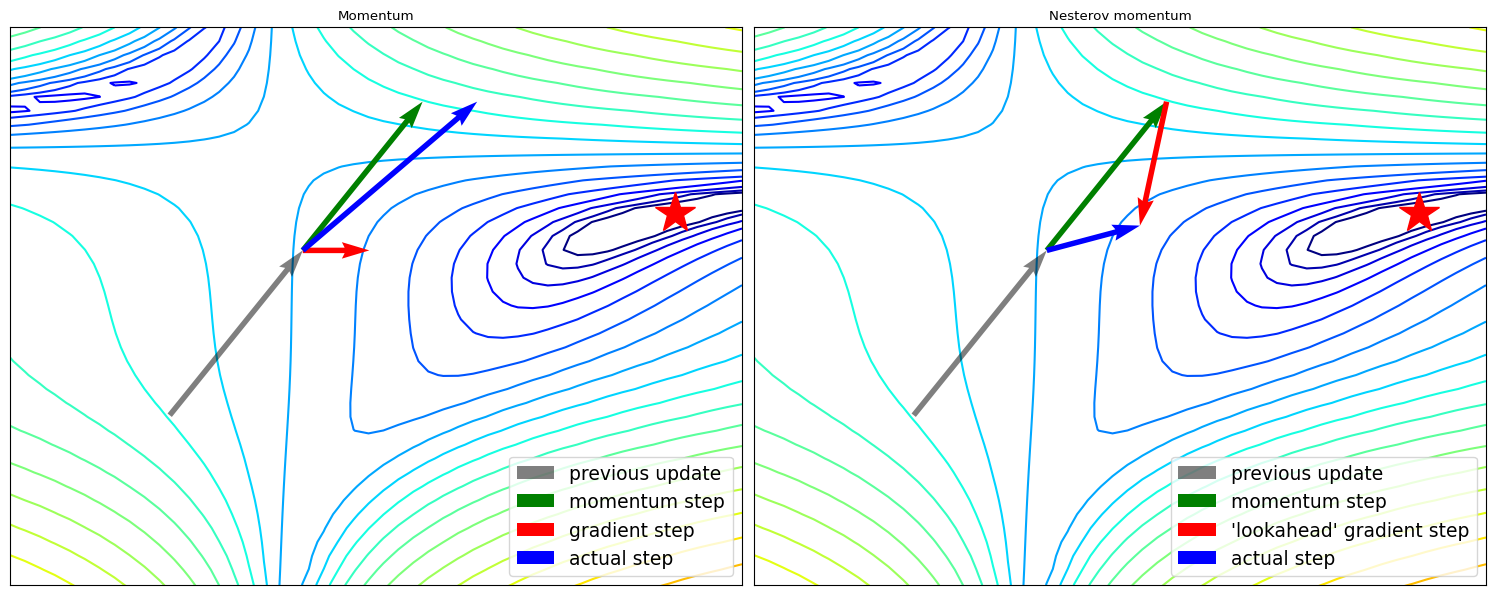

In [29]:
fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,4*fig_scale))
plot_nesterov(axes[0],method="Momentum")
plot_nesterov(axes[1],method="Nesterov momentum")

#### Momentum in practice

In [30]:
@interact
def compare_optimizers(iterations=(1,100,1), optimizer1=opt_names, optimizer2=opt_names):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    plot_optimizers(ax,iterations,[optimizer1,optimizer2])

interactive(children=(IntSlider(value=50, description='iterations', min=1), Dropdown(description='optimizer1',…

In [31]:
if not interactive:
    fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,3.5*fig_scale))
    optimizers = [['sgd','momentum'], ['momentum','nesterov']]
    for function, ax in zip(optimizers,axes):
        plot_optimizers(ax,100,function)
    plt.tight_layout();

### Gradients adaptatifs
* 'Corriger' le taux d'apprentissage pour chaque $w_i$ en fonction des conditions locales spécifiques (profondeur de couche, nombre de neurones sur la couche d'entree,...)
* Adagrad : échelle $\eta$ selon la somme carrée des gradients précédents $G_{i,(s)} = \sum_{t=1}^s \nabla \mathcal{L}(w_{i,(t)} )^2$
     * Règle de mise à jour pour $w_i$. Habituellement $\epsilon=10^{-7}$ (évite la division par 0), $\eta=0.001$.
$$w_{i,(s+1)} = w_{i,(s)} - \frac{\eta}{\sqrt{G_{i,(s)}+\epsilon}} \nabla \mathcal{ L}(w_{i,(s)})$$
* RMSProp : utilisez la _moyenne mobile_ des gradients carrés $m_{i,(s)} = \gamma m_{i,(s-1)} + (1-\gamma) \nabla \mathcal{L}(w_{i, (s)})^2$
     * Évite que les dégradés diminuent jusqu'à 0 à mesure que $G_{i,(s)}$ grandit. Habituellement $\gamma=0,9, \eta=0,001$
$$w_{i,(s+1)} = w_{i,(s)}- \frac{\eta}{\sqrt{m_{i,(s)}+\epsilon}} \nabla \mathcal{ L}(w_{i,(s)})$$

In [32]:
if not interactive:
    fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,2.6*fig_scale))
    optimizers = [['sgd','adagrad', 'rmsprop'], ['rmsprop','rmsprop_mom']]
    for function, ax in zip(optimizers,axes):
        plot_optimizers(ax,100,function)
    plt.tight_layout();

In [33]:
@interact
def compare_optimizers(iterations=(1,100,1), optimizer1=opt_names, optimizer2=opt_names):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    plot_optimizers(ax,iterations,[optimizer1,optimizer2])

interactive(children=(IntSlider(value=50, description='iterations', min=1), Dropdown(description='optimizer1',…

### Adam (Estimation adaptative du moment)
* Adam : RMSProp + momentum. Ajoute également une moyenne mobile pour les gradients ($\gamma_2$ = momentum) :
     * Ajoute une correction de biais pour éviter les petits gradients initiaux : $\hat{m}_{i,(s)} = \frac{m_{i,(s)}}{1-\gamma}$ et $\hat{ g}_{i,(s)} = \frac{g_{i,(s)}}{1-\gamma_2}$
 $$g_{i,(s)} = \gamma_2 g_{i,(s-1)} + (1-\gamma_2) \nabla \mathcal{L}(w_{i,(s)})$$
 $$w_{i,(s+1)} = w_{i,(s)}- \frac{\eta}{\sqrt{\hat{m}_{i,(s)}+\epsilon}} \hat{g}_{i,(s)}$$

    * Adamax : Idem, mais utilisez max() au lieu de la moyenne mobile : $u_{i,(s)} = max(\gamma u_{i,(s-1)}, |\mathcal{L}(w_{i ,(s)})|)$
$$w_{i,(s+1)} = w_{i,(s)}- \frac{\eta}{u_{i,(s)}} \hat{g}_{i,(s) }$$

In [34]:
if not interactive:
    # fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,2.6*fig_scale))
    # optimizers = [['sgd','adam'], ['adam','adamax']]
    # for function, ax in zip(optimizers,axes):
    #     plot_optimizers(ax,100,function)
    # plt.tight_layout();
    
    fig, axes = plt.subplots(1,1, figsize=(5*fig_scale,2.6*fig_scale))
    optimizers = [['sgd','adam']]
    plot_optimizers(axes,100,['sgd','adam'])
    plt.tight_layout();

In [35]:
@interact
def compare_optimizers(iterations=(1,100,1), optimizer1=opt_names, optimizer2=opt_names):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    plot_optimizers(ax,iterations,[optimizer1,optimizer2])

interactive(children=(IntSlider(value=50, description='iterations', min=1), Dropdown(description='optimizer1',…

### SGD Optimiseur Zoo
* RMSProp fonctionne souvent bien, mais essayez des alternatives. Pour encore plus d'optimiseurs, [voir ici](https://ruder.io/optimizing-gradient-descent).

In [36]:
if not interactive:
    fig, ax = plt.subplots(1,1, figsize=(10*fig_scale,5.5*fig_scale))
    plot_optimizers(ax,100,opt_names)

In [37]:
@interact
def compare_optimizers(iterations=(1,100,1)):
    fig, ax = plt.subplots(figsize=(10*fig_scale,6*fig_scale))
    plot_optimizers(ax,iterations,opt_names)

interactive(children=(IntSlider(value=50, description='iterations', min=1), Output()), _dom_classes=('widget-i…

In [38]:
from tensorflow.keras import models
from tensorflow.keras import layers
from numpy.random import seed
from tensorflow.random import set_seed
import random
import os

#Trying to set all seeds
os.environ['PYTHONHASHSEED']=str(0)
random.seed(0)
seed(0)
set_seed(0)
seed_value= 0

## Les réseaux de neurones en pratique
* Il existe de nombreux cours pratiques sur la formation des réseaux neuronaux. Par exemple.:
     * Avec TensorFlow : https://www.tensorflow.org/resources/learn-ml
     * Avec PyTorch : [cours fast.ai](https://course.fast.ai/), https://pytorch.org/tutorials/
* Ici, nous utiliserons Keras, une API générale pour créer des réseaux de neurones
     * API par défaut pour TensorFlow, dispose également de backends pour CNTK, Theano
* Se concentrer sur les décisions clés de conception, l'évaluation et la régularisation
    * Exemple courant : Fashion-MNIST
    * Images 28x28 pixels de 10 classes d'articles de mode

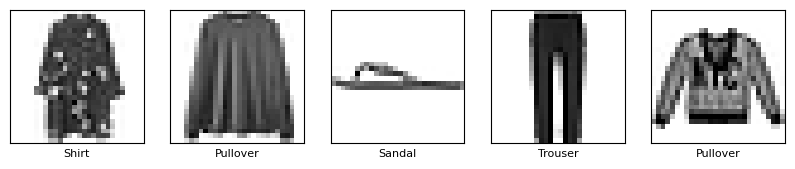

In [39]:
# Download FMINST data. Takes a while the first time.
mnist = oml.datasets.get_dataset(40996)
X, y, _, _ = mnist.get_data(target=mnist.default_target_attribute, dataset_format='array');
X = X.reshape(70000, 28, 28)
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

# Take some random examples
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X[n], cmap=plt.cm.gray_r)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("{}".format(fmnist_classes[y[n]]))
plt.show();

### Construire le réseau
* Nous construisons d'abord un modèle séquentiel simple (pas de branches)
* Couche d'entrée (« input_shape ») : un vecteur plat de 28*28=784 nœuds
     * Nous verrons plus tard comment gérer correctement les images
* Deux couches cachées denses : 512 nœuds chacune, activation ReLU
     * L'initialisation du poids Glorot est appliquée par défaut
* Couche de sortie : 10 nœuds (pour 10 classes) et activation softmax

``` python
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))
```

In [40]:
from tensorflow.keras import initializers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))

#### Résumé du modèle
- Beaucoup de paramètres (poids et biais) à apprendre !
     - couche cachée 1 : (28 * 28 + 1) * 512 = 401920
     - couche cachée 2 : (512 + 1) * 512 = 262656
     - couche de sortie : (512 + 1) * 10 = 5130
 
``` python
network.summary()
```

In [41]:
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669706 (2.55 MB)
Trainable params: 669706 (2.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Choisir la loss, l'optimiseur, les métriques
* __Fonction de loss__
     - Entropie croisée (log loss) pour la classification multi-classes ($y_{true}$ est onehot-encode)
     - Utiliser la crossentropie binaire pour les problèmes binaires (nœud de sortie unique)
     - Utilisez une entropie croisée catégorielle clairsemée (spare categorical crossentropy) si $y_{true}$ est codé par étiquette (1,2,3,...)
* __Optimiseur__
     - N'importe lequel des optimiseurs dont nous avons discuté précédemment. RMSprop fonctionne généralement bien.
* __Metriques__
 - Pour surveiller les performances pendant l'entrainement et l'evaluation, par ex. accuracy
 
``` python
# Shorthand
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# Detailed
network.compile(loss=CategoricalCrossentropy(label_smoothing=0.01),
                optimizer=RMSprop(learning_rate=0.001, momentum=0.0)
                metrics=[Accuracy()])
```

In [42]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Prétraitement : Normalisation, Redimensionnement, Encodage
* Normalisez toujours (standardisez ou min-max) les entrées. La moyenne doit être proche de 0.
     - Évitez que certaines entrées dominent les autres
     - Accélérer la convergence
     - Les gradients des fonctions d'activation $\frac{\partial a_{h}}{\partial z_{h}}$ sont (proches) de 0 pour les grandes entrées
     - Si certains gradients deviennent beaucoup plus importants que d'autres, SGD commencera à zigzaguer
* Redimensionnez les données pour les adapter à la forme de la couche d'entrée, par ex. (n, 28*28) ou (n, 28,28)
     - Tenseur avec instances en première dimension, le reste doit correspondre à la couche d'entrée
* Dans la classification multi-classes, chaque classe est un nœud de sortie, donc recodez les étiquettes
     - par exemple. la classe '4' devient [0,0,0,0,1,0,0,0,0,0]

```python
X = X.astype('float32') / 255
X = X.reshape((60000, 28 * 28))
y = to_categorical(y)
```

In [43]:
from sklearn.model_selection import train_test_split
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X, y, train_size=60000, shuffle=True, random_state=0)

Xf_train = Xf_train.reshape((60000, 28 * 28))
Xf_test = Xf_test.reshape((10000, 28 * 28))

# TODO: check if standardization works better
Xf_train = Xf_train.astype('float32') / 255
Xf_test = Xf_test.astype('float32') / 255

from tensorflow.keras.utils import to_categorical
yf_train = to_categorical(yf_train)
yf_test = to_categorical(yf_test)

### Choisir les hyperparamètres d'entraînement
* Nombre d'époques : suffisant pour permettre la convergence
     * Trop : le modèle commence à être surentraine (ou perd simplement du temps)
* Taille des lots (Batch size) : petits lots (par exemple 32, 64,... échantillons) souvent préférés
     * Les données d'entraînement « bruyantes » rendent le surapprentissage moins probable
     * Les lots plus importants se généralisent moins bien (« écart de généralisation »)
     * Nécessite moins de mémoire (surtout dans les GPU)
     * Les gros lots accélèrent l'entrainement et peuvent converger en moins d'époques
* [La taille du lot interagit avec le taux d'apprentissage](https://openreview.net/pdf?id=B1Yy1BxCZ)
 * Au lieu de réduire le taux d'apprentissage, vous pouvez augmenter la taille du lot

```python
history = network.fit(X_train, y_train, epochs=3, batch_size=32) ;
```

In [44]:
history = network.fit(Xf_train, yf_train, epochs=3, batch_size=32, verbose=0);

### Prédictions et évaluations
Nous pouvons maintenant appeler « predict » pour générer des prédictions et évaluer le modèle entraîné sur toutl'ensemble de test.

``` python
network.predict(X_test)
test_loss, test_acc = network.evaluate(X_test, y_test)
```

[0.071723  0.0083036 0.7915804 0.0144325 0.0407465 0.0000002 0.0720937
 0.0000003 0.001119  0.0000007]


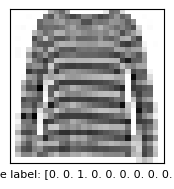

In [45]:
np.set_printoptions(precision=7)
fig, axes = plt.subplots(1, 1, figsize=(2, 2))
sample_id = 4
axes.imshow(Xf_test[sample_id].reshape(28, 28), cmap=plt.cm.gray_r)
axes.set_xlabel("True label: {}".format(yf_test[sample_id]))
axes.set_xticks([])
axes.set_yticks([])
print(network.predict(Xf_test, verbose=0)[sample_id])

In [46]:
test_loss, test_acc = network.evaluate(Xf_test, yf_test, verbose=0)
print('Test accuracy:', test_acc)

Test accuracy: 0.8776000142097473


## Sélection du modèle
* De combien d'époques avons-nous besoin pour l'entrainement ?
* Entraînez le réseau neuronal et suivez la perte après chaque itération sur un ensemble de validation
     * Vous pouvez ajouter un rappel(callback) à la version adaptée pour obtenir des informations sur chaque époque
* Meilleur modèle après quelques époques, puis commence le surapprentissage

In [47]:
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

# For plotting the learning curve in real time
class TrainingPlot(Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        self.max_acc = 0
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.max_acc = max(self.max_acc, logs.get('val_accuracy'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure(figsize=(8,3))
            plt.plot(N, self.losses, lw=2, c="b", linestyle="-", label = "train_loss")
            plt.plot(N, self.acc, lw=2, c="r", linestyle="-", label = "train_acc")
            plt.plot(N, self.val_losses, lw=2, c="b", linestyle=":", label = "val_loss")
            plt.plot(N, self.val_acc, lw=2, c="r", linestyle=":", label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}, Max Acc {:.4f}]".format(epoch, self.max_acc))
            plt.xlabel("Epoch #", fontsize=18*fig_scale)
            plt.ylabel("Loss/Accuracy", fontsize=18*fig_scale)
            plt.legend(prop={'size': 15*fig_scale})
            plt.tick_params(axis='both', labelsize=16*fig_scale)
            plt.show()

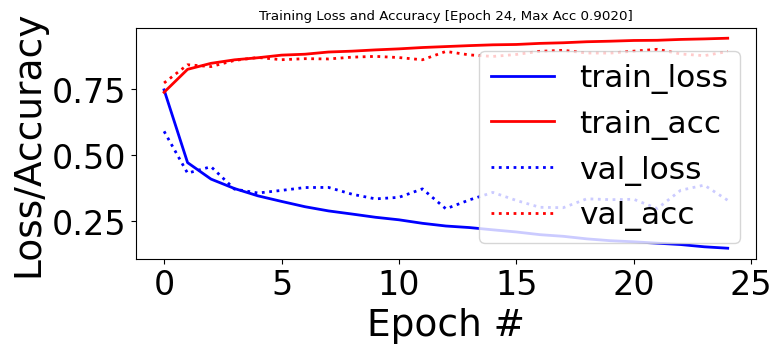

In [48]:
from sklearn.model_selection import train_test_split

x_val, partial_x_train = Xf_train[:10000], Xf_train[10000:]
y_val, partial_y_train = yf_train[:10000], yf_train[10000:] 
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=25, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses])

### Arrêt anticipé
* Arrêtez l'entrainement lorsque la perte de validation (ou l'accuracy de la validation) ne s'améliore plus
* La perte peut être irrégulière : utilisez une moyenne mobile ou attendez des étapes de k$ sans amélioration

``` python
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, epochs=25, batch_size=512, callbacks=[earlystop])
```

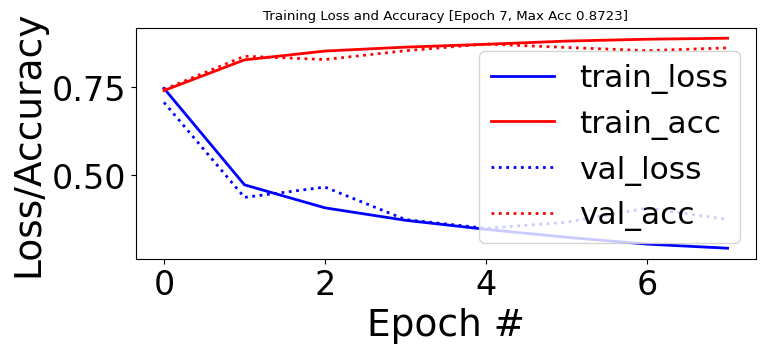

In [49]:
from tensorflow.keras import callbacks

earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=3)

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=25, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses, earlystop])

### Capacité de régularisation et de mémorisation
* Le nombre de paramètres apprenables est appelé la _capacité_ du modèle
* Un modèle avec plus de paramètres a une _capacité de mémorisation_ plus élevée
     - Une capacité trop élevée entraîne un surapprentissage, une capacité trop faible entraîne un sous-apprentissage
     - À l'extrême, l'ensemble d'entraînement peut être « mémorisé » dans les poids
* Les modèles plus petits sont obligés d'apprendre une représentation compressée qui généralise mieux
     - Trouvez le sweet spot : par ex. commencez avec quelques paramètres, augmentez jusqu'à ce que le surapprentissage commence.
* Exemple : 256 nœuds dans la première couche, 32 nœuds dans la deuxième couche, performances similaires

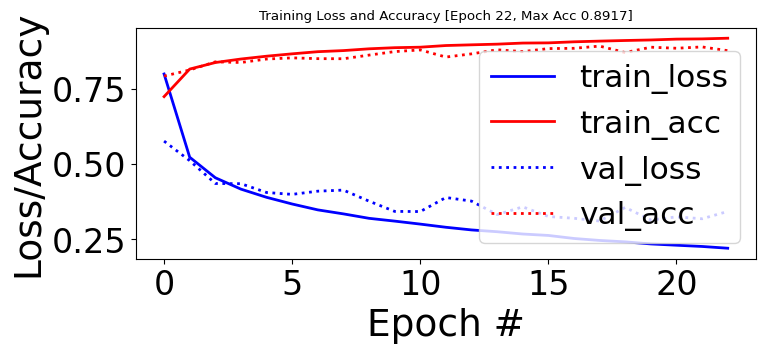

In [50]:
network = models.Sequential()
network.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
earlystop5 = callbacks.EarlyStopping(monitor='val_loss', patience=5)
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=30, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses, earlystop5])

#### Goulet d'étranglement des informations
* Si une couche est trop étroite, elle perdra des informations qui ne pourront jamais être récupérées par les couches suivantes
* La théorie du _goulot d'étranglement de l'information_ définit une limite sur la capacité du réseau
* Imaginez que vous ayez besoin d'apprendre 10 sorties (par exemple des classes) et que votre couche cachée comporte 2 nœuds
     * C'est comme essayer d'apprendre 10 hyperplans à partir d'une représentation bidimensionnelle
* Exemple : goulot d'étranglement de 2 nœuds, pas de surapprentissage, perte d'entraînement beaucoup plus élevée

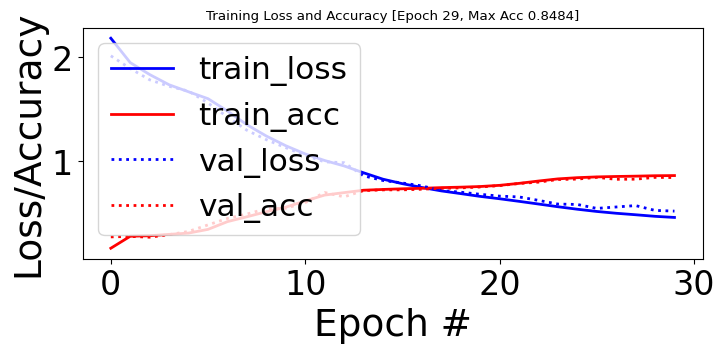

In [51]:
network = models.Sequential()
network.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(2, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
earlystop5 = callbacks.EarlyStopping(monitor='val_loss', patience=5)
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=30, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses, earlystop5])

#### Régularisation du poids (dégradation du poids, weight decay)
* Comme nous l'avons fait à plusieurs reprises auparavant, nous pouvons également ajouter la régularisation du poids à notre fonction de perte
    - Régularisation L1 : conduit à des _réseaux clairsemés_ avec de nombreux poids égaux à 0
    - Régularisation L2 : conduit à de nombreux poids très petits

``` python
network = models.Sequential()
network.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(28 * 28,)))
network.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
```

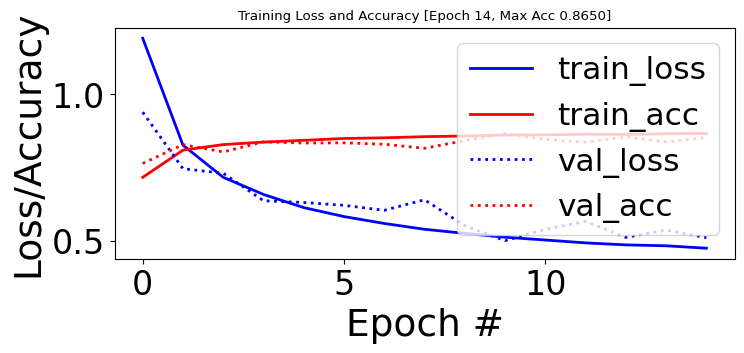

In [52]:
from tensorflow.keras import regularizers

network = models.Sequential()
network.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(28 * 28,)))
network.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
earlystop5 = callbacks.EarlyStopping(monitor='val_loss', patience=5)
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=50, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses, earlystop5])

### Dropout
* À chaque itération, définissez aléatoirement un nombre d'activations $a_i$ à 0
* _Taux de dropout_ : fraction des sorties qui sont mises à zéro (par exemple 0,1 - 0,5)
* Idée : briser les schémas appris accidentels et non significatifs
* Au moment du test, rien n'est abandonné, mais les valeurs de sortie sont réduites en fonction du taux de dropout.
 - Compense le fait que plus d'unités sont actives que pendant l'entraînement

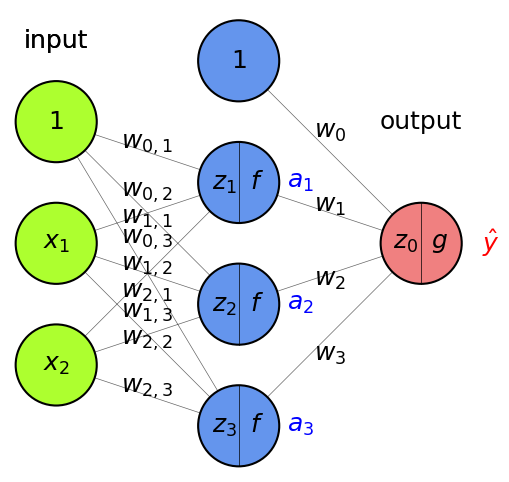

In [53]:
fig = plt.figure(figsize=(4*fig_scale, 4*fig_scale))
ax = fig.gca()
draw_neural_net(ax, [2, 3, 1], draw_bias=True, labels=True, 
                show_activations=True, activation=True)

#### Couches de Dropout
* Le dropout est généralement implémenté en tant que couche spéciale
``` python
network = models.Sequential()
network.add(layers.Dense(256, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(10, activation='softmax'))
```

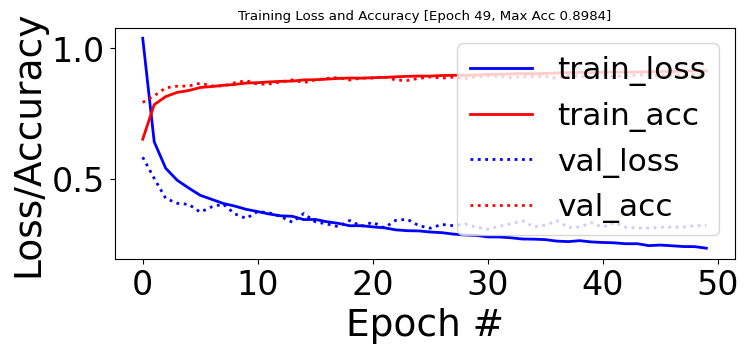

In [54]:
network = models.Sequential()
network.add(layers.Dense(256, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dropout(0.3))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dropout(0.3))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=50, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses])

#### Normalisation par batchs
* Nous avons vu que la mise à l'échelle de l'entrée est importante, mais que se passe-t-il si les activations de couches deviennent très importantes ?
     * Mêmes problèmes, en commençant plus profondément dans le réseau
* Normalisation par lots : normalisez les activations de la couche précédente au sein de chaque lot
     * Au sein d'un lot, régler la moyenne d'activation proche de 0 et l'écart type proche de 1
     * Pour tous les batchs, utilisez la moyenne mobile exponentielle de la moyenne et de la variance par lot
 * Permet des réseaux plus profonds moins sujets à la disparition ou à l'explosion des gradients

``` python
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
```

```python

```


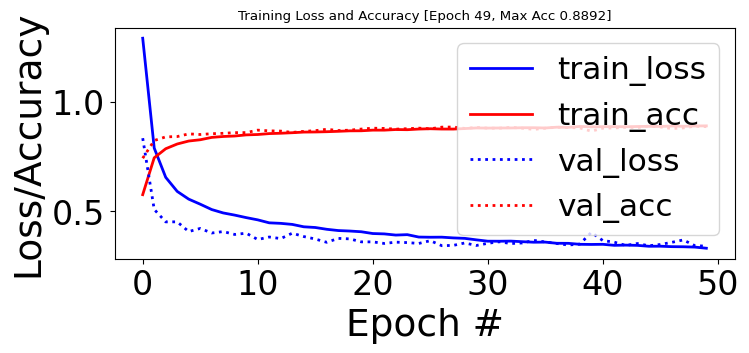

In [55]:
network = models.Sequential()
network.add(layers.Dense(265, activation='relu', input_shape=(28 * 28,)))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=50, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses])

### Réglage de plusieurs hyperparamètres
* Vous pouvez envelopper les modèles Keras en tant que modèles scikit-learn et utiliser n'importe quelle technique de réglage
* Keras intègre également RandomSearch (et HyperBand et BayesianOptimization - voir plus tard)

```python
def make_model(hp):
    m.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32)))
    m.compile(optimizer=Adam(hp.Choice('learning rate', [1e-2, 1e-3, 1e-4])))
    return model
```

```python
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
clf = KerasClassifier(make_model)
grid = GridSearchCV(clf, param_grid=param_grid, cv=3)

from kerastuner.tuners import RandomSearch
tuner = keras.RandomSearch(build_model, max_trials=5)
```

## Résumé

* Architectures neuronales
* Formation des réseaux neuronaux
     * Forward pass : opérations tensorielles
     * Backward pass : rétropropagation
* Conception de réseaux neuronaux :
     * Fonctions d'activation
     * Initialisation du poids
     * Optimiseurs
* Les réseaux de neurones en pratique
* Sélection du modèle
     * Arrêt anticipé (Early stopping)
     * Capacité de mémorisation et goulot d'étranglement de l'information
     * Régularisation L1/L2
     * Dropout
     * Normalisation des batchs